# Model Selection: Dataset 6

In [339]:
# Import libraries and modules
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import r2_score, classification_report, confusion_matrix,           \
                            roc_curve, roc_auc_score, plot_confusion_matrix, f1_score,   \
                            balanced_accuracy_score, accuracy_score, mean_squared_error, \
                            log_loss
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier,    \
                                 Lasso, lasso_path
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

import scipy
from scipy import stats

import os
import shutil
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import itertools

import time
import tqdm
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset

import PIL
import joblib
import json

# import mysgd

In [340]:
# Import user-defined modules
import sys
import imp
sys.path.append('/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockdown')
import tools_general as tg
import tools_pytorch as tp
import lockdown      as ld
imp.reload(tg)
imp.reload(tp)
imp.reload(ld)

<module 'lockdown' from '/Users/arbelogonzalezw/Documents/ML_WORK/LIBS/Lockdown/lockdown.py'>

## Read, clean, and save data

In [19]:
# Read X and Y
df1 = pd.read_csv('dataset/arcene_train.data',
                  sep='\s+',
                  header=None, 
                  index_col=False)
df2 = pd.read_csv('dataset/arcene_valid.data',
                  sep='\s+',
                  header=None, 
                  index_col=False)
X = df1.append(df2, ignore_index=True)
X = X.astype(float)

# 
y1 = pd.read_csv('dataset/arcene_train.labels',
                  sep='\s+',
                  header=None, 
                  index_col=False)
y2 = pd.read_csv('dataset/arcene_valid.labels',
                  sep='\s+',
                  header=None, 
                  index_col=False)
Y = y1.append(y2, ignore_index=True)
Y.replace({-1: 0}, inplace=True)

X = X.replace('?', np.nan)
Y = Y.replace('?', np.nan)

cols_all = X.columns.astype(str).tolist()
X.columns = cols_all
Y.columns = ['target']

In [20]:
# Split and save data set
xtrain, xvalid, xtest, ytrain, yvalid, ytest = tg.split_data(X, Y, 
                                                             test_size1=0.20, test_size2=0.25, 
                                                             seed1=0, seed2=42)
tg.save_data(X, xtrain, xvalid, xtest, Y, ytrain, yvalid, ytest, 'dataset/')
tg.save_list(X.columns.to_list(), 'dataset/X.columns')
tg.save_list(Y.columns.to_list(), 'dataset/Y.columns')

# 
print("- X size: {}\n".format(X.shape))
print("- xtrain size: {}".format(xtrain.shape))
print("- xvalid size: {}".format(xvalid.shape))
print("- xtest size: {}".format(xtest.shape))

- X size: (200, 10000)

- xtrain size: (120, 10000)
- xvalid size: (40, 10000)
- xtest size: (40, 10000)


In [6]:
# Select type of processor to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cuda'):
    print("-Type of precessor to be used: 'gpu'")
    !nvidia-smi
else:
    print("-Type of precessor to be used: 'cpu'")
    
# Choose device
# torch.cuda.set_device(6)

-Type of precessor to be used: 'cpu'


In [21]:
# Read data
X, x_train, x_valid, x_test, Y, ytrain, yvalid, ytest = tp.load_data_clf('dataset/')
cols_X = tg.read_list('dataset/X.columns')
cols_Y = tg.read_list('dataset/Y.columns')

In [22]:
# Normalize data
xtrain, xvalid, xtest = tp.normalize_x(x_train, x_valid, x_test)

In [23]:
# Create dataloaders
dl_train, dl_valid, dl_test = tp.make_DataLoaders(xtrain, xvalid, xtest, ytrain, yvalid, ytest, 
                                                  tp.dataset_tabular, batch_size=10000)

(train, valid, test) = (1, 1, 1)


In [24]:
# NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True)        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

In [134]:
# NN architecture with its corresponding forward method
class MyNet(nn.Module):
    
# .Network architecture
    def __init__(self, features, layer_sizes):
        super(MyNet, self).__init__()
        
        self.classifier = nn.Sequential(
            nn.Linear(features, layer_sizes[0], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[0], layer_sizes[1], bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(layer_sizes[1], layer_sizes[2], bias=True)
        )

# .Forward function
    def forward(self, x):
        x = self.classifier(x)
        return x

## Forward

In [367]:
# Load best forward model
n_features = len(cols_X)
n_layers = [5, 2]
model = MyNet(n_features, n_layers)
model.eval()

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=10000, out_features=5, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=5, out_features=2, bias=True)
  )
)

Epochs:   0%|          | 0/10000 [00:00<?, ?it/s]

Early stopping = True
Last iteration = 2062
Best validation at iteration = 515


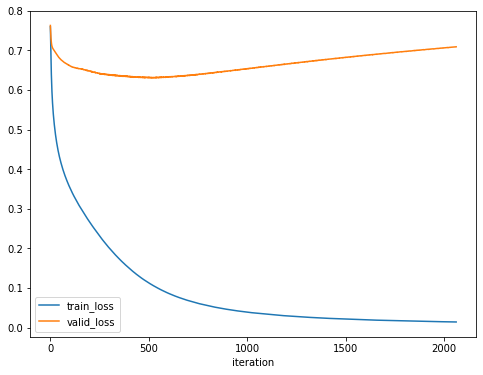

In [369]:
# TRAIN FORWARD
lockdown_unconstraint = ld.lockdown(model, lr=1e-3, loss_type=2, optim_id=1)

lockdown_unconstraint.train(dl_train, dl_valid, epochs=10000, early_stop=20, tol_loss=1e-5,
                            train_how="unconstraint", reset_weights=True)

lockdown_unconstraint.path_data.plot(x="iteration", 
                                     y=['train_loss', 'valid_loss'], 
                                     figsize=(8,6))
plt.show()

In [370]:
# Save model, data
tp.save_model(lockdown_unconstraint.model_best_valid, 'model_forward_valid_min.pth')
tp.save_model(lockdown_unconstraint.model_last, 'model_forward_last.pth')
lockdown_unconstraint.path_data.to_csv('data_forward.csv')

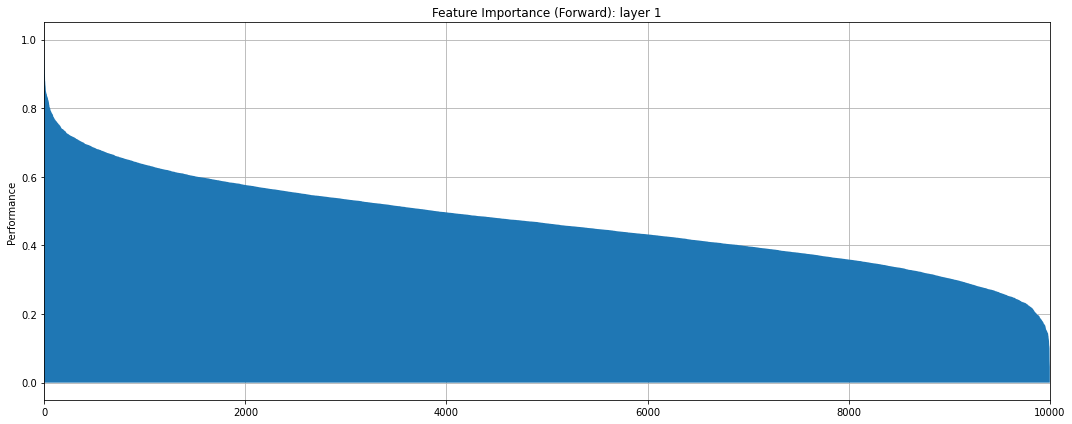

Non zero features: 10000


In [372]:
# Weight importance (layer 1)
mm = MyNet(n_features, n_layers)
mm.load_state_dict(torch.load('./model_forward_valid_min.pth'))
mm.eval()

importance = tp.get_features_importance(mm, 'classifier.0.weight')

fig, axes = plt.subplots(figsize=(15,6))
x_pos = np.arange(len(importance))
axes.fill_between(x_pos, importance, zorder=2)
# axes.set_xticks(x_pos)
# axes.set_xticklabels(feature_importance_sorted1.index[idx], rotation='vertical')
axes.set_xlim(-1,len(x_pos))
axes.set_ylabel('Performance')
axes.set_title('Feature Importance (Forward): layer 1')
axes.grid(True, zorder=1)

plt.tight_layout()
# plt.savefig('feature_importance_forward.pdf', bbox_inches='tight')
plt.show()
print("Non zero features: {}".format(len(importance)))

## Lockdown: 1 hidden-layer (5)

In [103]:
# TRAIN WITH LOCKDOWN
model = MyNet(n_features, n_layers)
model.load_state_dict(torch.load('./model_forward_valid_min.pth'))
model.eval()

regul_type = [('classifier.0.weight', 1)]
regul_path = [('classifier.0.weight', True)]

lockdown_clf2 = ld.lockdown(model, lr=1e-3, 
                            regul_type=regul_type,
                            regul_path=regul_path, 
                            loss_type=2, tol_grads=1e-2)

In [104]:
lockdown_clf2.train(dl_train, dl_valid, dl_test, epochs=150000, early_stop=10, tol_loss=1e-4,
                    train_how="decrease_t0")

Epochs1:   0%|          | 0/150000 [00:00<?, ?it/s]

Path 1: Early stopping = True
        Last iteration = 6048


Epochs2:   0%|          | 0/150000 [00:00<?, ?it/s]

Best validation at iteration = 3


In [105]:
lockdown_clf2.path_data

,iteration,sparcity__classifier.0.weight,t0_calc__classifier.0.weight,t0_used__classifier.0.weight,train_loss,valid_loss,test_loss,train_accu,valid_accu,test_accu
0,1,1.0000,251.409180,251.409180,0.326859,0.626456,0.504117,0.933333,0.700,0.700
1,2,1.0000,251.409271,251.409180,0.326195,0.630179,0.505301,0.933333,0.700,0.700
2,3,1.0000,251.409103,251.409180,0.324612,0.624759,0.503530,0.933333,0.700,0.700
3,4,1.0000,251.409164,251.409180,0.323635,0.628590,0.504457,0.933333,0.700,0.700
4,5,1.0000,251.409119,251.409180,0.321977,0.627752,0.503214,0.933333,0.700,0.700
...,...,...,...,...,...,...,...,...,...,...
156042,156043,0.0066,2.025780,0.008377,0.676939,0.740310,0.677703,0.566667,0.575,0.525
156043,156044,0.0066,2.025720,0.006699,0.676939,0.740307,0.677704,0.566667,0.575,0.525
156044,156045,0.0066,2.025659,0.005020,0.676939,0.740304,0.677705,0.566667,0.575,0.525
156045,156046,0.0066,2.025598,0.003342,0.676939,0.740301,0.677706,0.566667,0.575,0.525


In [106]:
# Save model, data
tp.save_model(lockdown_clf2.model_best_valid, 'model_lockout_valid_min2.pth')
tp.save_model(lockdown_clf2.model_last, 'model_lockout_last2.pth')
lockdown_clf2.path_data.to_csv('data_lockout2.csv')

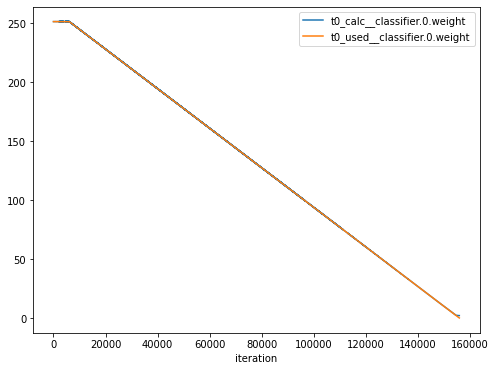

In [108]:
# Relevant plots
df = pd.read_csv('data_lockout2.csv')
df.plot('iteration', y=['t0_calc__classifier.0.weight', 't0_used__classifier.0.weight'], 
        figsize=(8,6))
# plt.xlim(1.2e5,1.6e5)
plt.show()

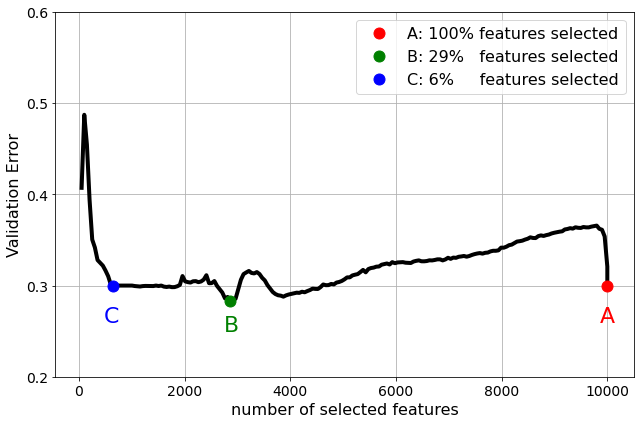

In [296]:
# Acc. v Sparcity (smooth)
nn = int(2e2)
data_lockdown = pd.read_csv('data_lockout2.csv', index_col=0)
data_tmp = pd.DataFrame(columns=['sparcity', 'train_accu', 'valid_accu', 'test_accu', 't0_used'])
xgrid, step = np.linspace(0., 1., num=nn,endpoint=True, retstep=True)
for x in xgrid:
    msk = (data_lockdown['sparcity__classifier.0.weight'] >= x) &    \
          (data_lockdown['sparcity__classifier.0.weight'] < x+step)
    train_accu = data_lockdown.loc[msk, 'train_accu'].mean()
    valid_accu = data_lockdown.loc[msk, 'valid_accu'].mean()
    test_accu  = data_lockdown.loc[msk, 'test_accu'].mean()
    t0_used = data_lockdown.loc[msk, 't0_used__classifier.0.weight'].mean()
    data_tmp = data_tmp.append({'sparcity': x, 
                                'train_accu': train_accu, 
                                'valid_accu': valid_accu, 
                                'test_accu': test_accu, 
                                't0_used': t0_used}, ignore_index=True)
data_tmp.dropna(axis='index', how='any', inplace=True)
data_tmp = data_tmp.append({'sparcity': data_lockdown.loc[0,'sparcity__classifier.0.weight'], 
                            'train_accu': data_lockdown.loc[0,'train_accu'], 
                            'valid_accu': data_lockdown.loc[0,'valid_accu'], 
                            'test_accu': data_lockdown.loc[0,'test_accu'], 
                            't0_used': data_lockdown.loc[0,'t0_used__classifier.0.weight']}, 
                           ignore_index=True)

fig, axes = plt.subplots(figsize=(9,6))

axes.plot(10000*data_tmp['sparcity'], 1.0 - data_tmp['valid_accu'], 
          "-", linewidth=4, markersize=10, color="black")
axes.plot(10000*data_tmp.loc[199,'sparcity'], 1.0 - data_tmp.loc[199,'valid_accu'], 
          "o", linewidth=4, markersize=11, color="r", label="A: 100% features selected")
axes.plot(10000*data_tmp.loc[data_tmp.valid_accu.idxmax(), 'sparcity'], 
          1.0 - data_tmp.loc[data_tmp.valid_accu.idxmax(), 'valid_accu'], 
          "o", linewidth=4, markersize=11, color="g", label="B: 29%   features selected")
axes.plot(10000*data_tmp.loc[12,'sparcity'], 1.0 - data_tmp.loc[12,'valid_accu'], 
          "o", linewidth=4, markersize=11, color="b", label="C: 6%     features selected")
axes.text(9850, 0.26, "A", fontsize=22, color="r")
axes.text(2750, 0.25, "B", fontsize=22, color="g")
axes.text(470, 0.26, "C", fontsize=22, color="b")

axes.grid(True, zorder=2)
axes.set_xlabel("number of selected features", fontsize=16)
axes.set_ylabel("Validation Error", fontsize=16)
axes.set_yticks(np.linspace(0.2, 0.6, 5))
axes.legend(fontsize=16)
axes.tick_params(axis='both', which='major', labelsize=14)
axes.set_ylim(0.2,0.6)

plt.tight_layout()
plt.savefig('error_vs_features_sec5.pdf', bbox_inches='tight')
plt.show()

In [286]:
data_tmp.loc[199,]

sparcity        1.000000
train_accu      0.960368
valid_accu      0.679182
test_accu       0.743877
t0_used       251.409180
valid_loss      0.966624
Name: 199, dtype: float64

In [277]:
data_tmp.loc[data_tmp.valid_accu.idxmax(),]

sparcity       0.286432
train_accu     0.999537
valid_accu     0.717187
test_accu      0.720139
t0_used       34.620031
valid_loss     0.769936
Name: 57, dtype: float64

In [282]:
data_tmp.loc[12,]

sparcity       0.060302
train_accu     1.000000
valid_accu     0.698872
test_accu      0.725000
t0_used       18.953872
valid_loss     0.653737
Name: 12, dtype: float64